## JUPITER

In [66]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord
from collections import defaultdict
import datetime
from utils import *

In [48]:
jcoords = np.loadtxt("../data/Jupiter-ScWs.txt", delimiter=",", skiprows=1, usecols=(4, 5))
jupiter_ra = jcoords[:, 0]
jupiter_dec = jcoords[:, 1]

jdates = np.loadtxt("../data/Jupiter-ScWs.txt", delimiter=",", skiprows=1, usecols=(2,), dtype=str)
jdates = [Time(jd, format="mjd").datetime for jd in jdates]

Total stack (over every ScW)

In [61]:
#dir = "../data/JupiterIMG_FITS_15_30"
dir = "../data/JupiterIMG_FITS_30_60"
#dir = "../data/JupiterIMG_FITS_3_15"

s_var = None
s_flu = None
total_max_isgri_exp = 0

body_lim = {}

body_name = 'Jupiter'

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        scw_id = scw[:16]
        
        f = fits.open(os.path.join(dir, scw))

        sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
        var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
        flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
        expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

        wcs = WCS(sig.header)

        date_obs = Time(sig.header['DATE-OBS']).datetime

        # Find closest Jupiter position in time
        closest_idx = np.argmin(np.abs([jdates[i] - date_obs for i in range(len(jdates))]))
        j_ra = jupiter_ra[closest_idx]
        j_dec = jupiter_dec[closest_idx]

        try:
            body_i, body_j = [
            int(i) for i in 
            wcs.world_to_pixel(SkyCoord(j_ra, j_dec, unit="deg"))
            ]
        except Exception as e:
            print(f"Coordinate transform failed: {e}")
            continue

        plot_span = 20
        detection_span = 20

        if False:
            plt.figure(figsize=(4,4))
            plt.imshow(
                #sig.data
                sig.data[body_i-plot_span:body_i+plot_span, body_j-plot_span:body_j+plot_span]
            )

        if False:
            plt.scatter(
                body_i,
                body_j,
                c='r',
                marker='o',
                s=200,
                alpha=0.2
            )

            plt.clim([0,6])

        f = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        ex = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

        try:
            if s_var is None:
                s_var = v.copy()
                s_flu = f.copy()
                s_expo = ex.copy()
            else:
                m = ~np.isnan(v)
                m &= v > 0
                
                s_flu[m] = (f[m]/v[m] + s_flu[m]/s_var[m])/(1/v[m] + 1/s_var[m])
                s_var[m] = 1/(1/v[m] + 1/s_var[m])
                s_expo[m] += ex[m]
                total_max_isgri_exp += np.nanmax(expo.data)
        except:
            print("fail to read!")
            continue
            
    
        body_lim[scw] = dict(
            ic = np.nanmean(v**0.5), 
            ic_std = np.nanstd(f), 
        )

/tmp/ipykernel_6489/954079303.py:88: RuntimeWarning: Mean of empty slice
  ic = np.nanmean(v**0.5),
/home/hthums/micromamba/envs/jupiter_xray/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!
fail to read!


Plotting

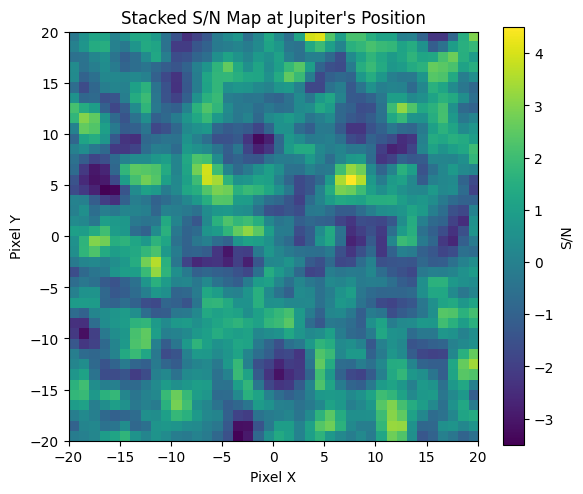

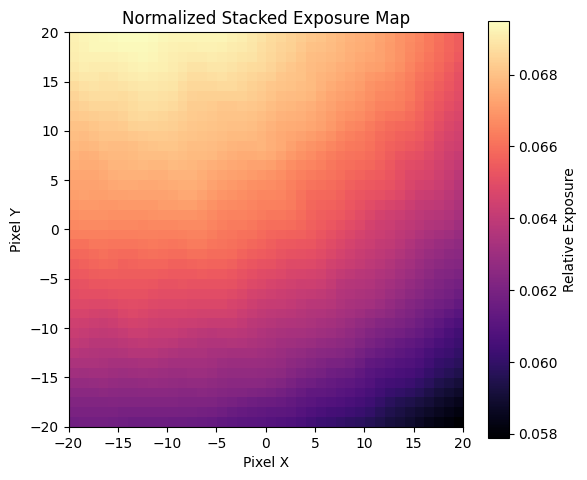

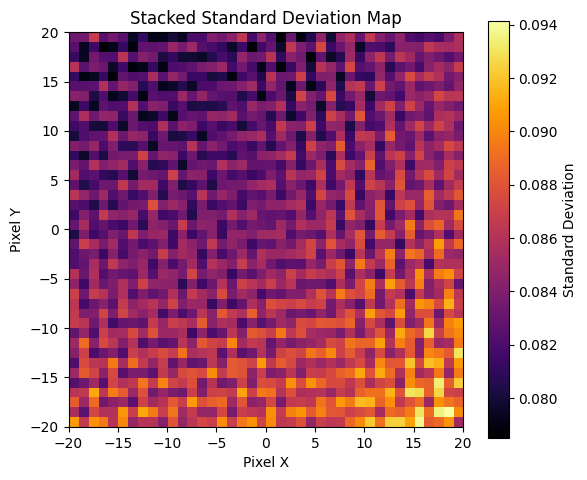

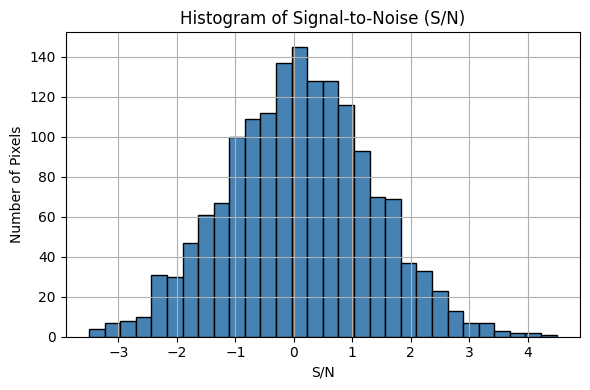

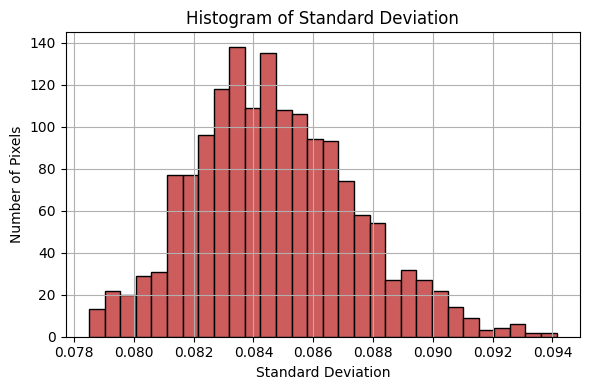

In [62]:
extent = [-detection_span, detection_span, -detection_span, detection_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Jupiter's Position")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo / total_max_isgri_exp, origin='lower', cmap='magma', extent=extent)
plt.title("Normalized Stacked Exposure Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Relative Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N)")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

Monthly stack

In [58]:
#dir = "../data/JupiterIMG_FITS_15_30"
dir = "../data/JupiterIMG_FITS_30_60"
#dir = "../data/JupiterIMG_FITS_3_15"

detection_span = 20
extent = [-detection_span, detection_span, -detection_span, detection_span]

monthly_stack = defaultdict(lambda: {
    's_flu': None,
    's_var': None,
    's_expo': None,
    'count': 0
})

body_name = 'Jupiter'

for scw in np.sort(os.listdir(dir)):
    if not scw.endswith(".fits"):
        continue

    try:
        f = fits.open(os.path.join(dir, scw))
        sig = [e for e in f if e.header.get('IMATYPE') == "SIGNIFICANCE"][0]
        var = [e for e in f if e.header.get('IMATYPE') == "VARIANCE"][0]
        flu = [e for e in f if e.header.get('IMATYPE') == "INTENSITY"][0]
        expo = [e for e in f if e.header.get('IMATYPE') == "EXPOSURE"][0]

        wcs = WCS(sig.header)
        date_obs = Time(sig.header['DATE-OBS']).datetime
        key = (date_obs.year, date_obs.month)
        
        # Find Jupiter position closest in time
        closest_idx = np.argmin(np.abs([jdates[i] - date_obs for i in range(len(jdates))]))
        j_ra = jupiter_ra[closest_idx]
        j_dec = jupiter_dec[closest_idx]
        coord = SkyCoord(j_ra, j_dec, unit="deg")
        body_i, body_j = [int(i) for i in wcs.world_to_pixel(coord)]

        # Crop around Jupiter
        f_crop = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v_crop = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        e_crop = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        
        # Check if cropped region has the right shape
        if f_crop.shape != (2 * detection_span, 2 * detection_span):
            print(f"Skipping {scw} due to crop shape: {f_crop.shape}")
            continue

        # Stack
        stack = monthly_stack[key]
        if stack['s_var'] is None:
            stack['s_flu'] = f_crop.copy()
            stack['s_var'] = v_crop.copy()
            stack['s_expo'] = e_crop.copy()
        else:
            m = ~np.isnan(v_crop)
            m &= v_crop > 0

            stack['s_flu'][m] = (f_crop[m]/v_crop[m] + stack['s_flu'][m]/stack['s_var'][m]) / (1/v_crop[m] + 1/stack['s_var'][m])
            stack['s_var'][m] = 1/(1/v_crop[m] + 1/stack['s_var'][m])
            stack['s_expo'][m] += e_crop[m]

        stack['count'] += 1

    except Exception as e:
        print(f"Failed on {scw}: {e}")
        continue

Skipping 007700330010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700340010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700350010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700360010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700370010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700380010.001mosaic.fits due to crop shape: (0, 25)
Skipping 007700390010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700400010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700410010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700460010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700460020.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700470010.001mosaic.fits due to crop shape: (0, 40)
Skipping 007700480010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700490010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700500010.001mosaic.fits due to crop shape: (0, 0)
Skipping 007700510010.001mosaic.fits due to cr

Light Curve

In [59]:
monthly_dates = []
monthly_sn = []

for (year, month), stack in sorted(monthly_stack.items()):
    if stack['s_flu'] is None or stack['s_var'] is None:
        continue
    if stack['s_flu'].shape != (2 * detection_span, 2 * detection_span):
        continue

    sn_map = stack['s_flu'] / np.sqrt(stack['s_var'])
    center_sn = sn_map[detection_span, detection_span]

    monthly_dates.append(datetime.datetime(year, month, 15))  # mid-month
    monthly_sn.append(center_sn)


/tmp/ipykernel_6489/1756205590.py:10: RuntimeWarning: invalid value encountered in divide
  sn_map = stack['s_flu'] / np.sqrt(stack['s_var'])


Plotting

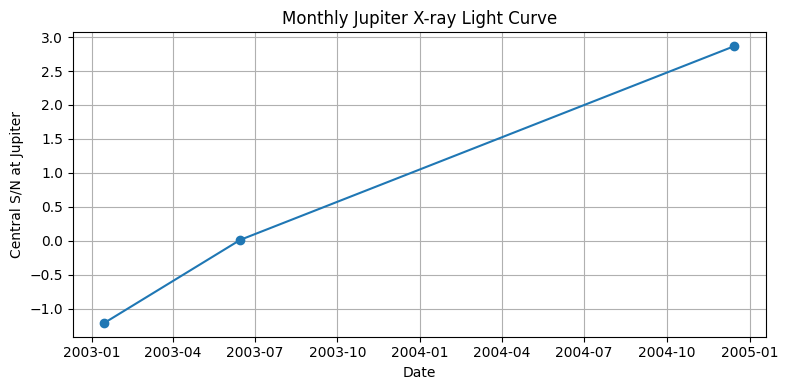

In [60]:
plt.figure(figsize=(8, 4))
plt.plot(monthly_dates, monthly_sn, marker='o')
plt.xlabel("Date")
plt.ylabel("Central S/N at Jupiter")
plt.title("Monthly Jupiter X-ray Light Curve")
plt.grid(True)
plt.tight_layout()

## CRAB

In [63]:
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg

In [101]:
#dir = "../data/CrabIMG_FITS_15_30"
dir = "../data/CrabIMG_FITS_30_60"
#dir = "../data/CrabIMG_FITS_3_15"

s_var = None
s_flu = None
s_expo = None
total_max_isgri_exp = 0

body_lim = {}

body_name = 'Crab'

# Fixed Crab Nebula coordinates
crab_coords = SkyCoord.from_name("Crab")
crab_ra = crab_coords.ra.deg
crab_dec = crab_coords.dec.deg

for scw in np.sort(os.listdir(dir)):
    if scw.endswith(".fits"):

        scw_id = scw[:16]
        
        f = fits.open(os.path.join(dir, scw))

        sig = [e for e in f if e.header.get('IMATYPE', None) == "SIGNIFICANCE"][0]
        var = [e for e in f if e.header.get('IMATYPE', None) == "VARIANCE"][0]
        flu = [e for e in f if e.header.get('IMATYPE', None) == "INTENSITY"][0]
        expo = [e for e in f if e.header.get('IMATYPE', None) == "EXPOSURE"][0]

        wcs = WCS(sig.header)

        try:
            body_i, body_j = [
                int(i) for i in 
                wcs.world_to_pixel(SkyCoord(crab_ra, crab_dec, unit="deg"))
            ]
        except Exception as e:
            print(f"Coordinate transform failed: {e}")
            continue

        plot_span = 20
        detection_span = 20

        if False:
            plt.figure(figsize=(4,4))
            plt.imshow(
                sig.data[body_i-plot_span:body_i+plot_span, body_j-plot_span:body_j+plot_span]
            )

        if False:
            plt.scatter(
                body_i,
                body_j,
                c='r',
                marker='o',
                s=200,
                alpha=0.2
            )
            plt.clim([0, 6])

        f = flu.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        v = var.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]
        ex = expo.data[body_i-detection_span:body_i+detection_span, body_j-detection_span:body_j+detection_span]

        try:
            if s_var is None:
                s_var = v.copy()
                s_flu = f.copy()
                s_expo = ex.copy()
            else:
                m = ~np.isnan(v)
                m &= v > 0

                s_flu[m] = (f[m]/v[m] + s_flu[m]/s_var[m])/(1/v[m] + 1/s_var[m])
                s_var[m] = 1/(1/v[m] + 1/s_var[m])
                s_expo[m] += ex[m]
                total_max_isgri_exp += np.nanmax(expo.data)
        except Exception as e:
            print(f"Failed to process SCW {scw_id}: {e}")
            continue

        body_lim[scw] = dict(
            ic=np.nanmean(np.sqrt(v)), 
            ic_std=np.nanstd(f),
        )

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 52695.589734 from DATE-OBS.
Set MJD-END to 52695.614757 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 52866.475914 from DATE-OBS.
Set MJD-END to 52866.501366 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53070.792419 from DATE-OBS.
Set MJD-END to 53070.813241 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53277.533958 from DATE-OBS.
Set MJD-END to 53277.554780 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53458.589340 from DATE-OBS.
Set MJD-END to 53458.610162 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53615.317153 from DATE-OBS.
Set MJD-END to 53615.358484 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53654.356829 from DATE-OBS.
Set MJD-END to 53654.377662 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 53823.883449 from DATE-OBS.
Set MJD-END to 53823.900799 from DATE-END'. [astropy.wcs.wcs]
Set MJD-OBS to 54007.336030 from DATE-OBS.
Set MJD-END to 54007.353553 from DATE-END'. [astr

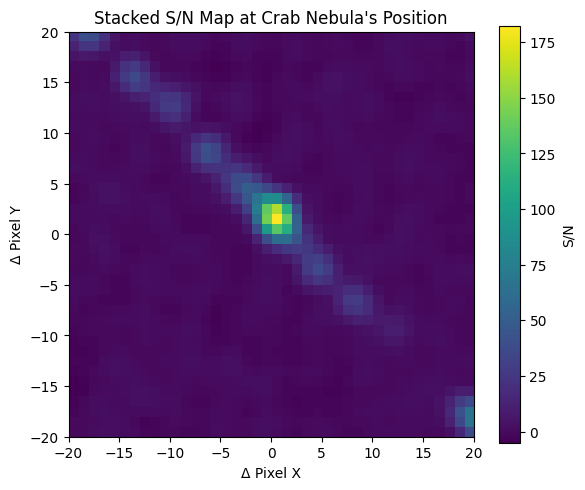

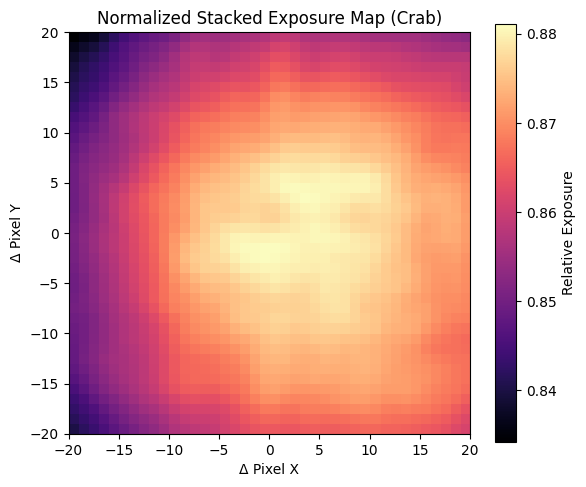

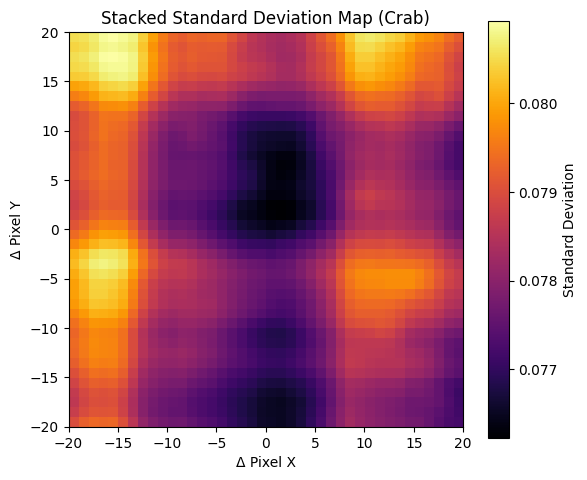

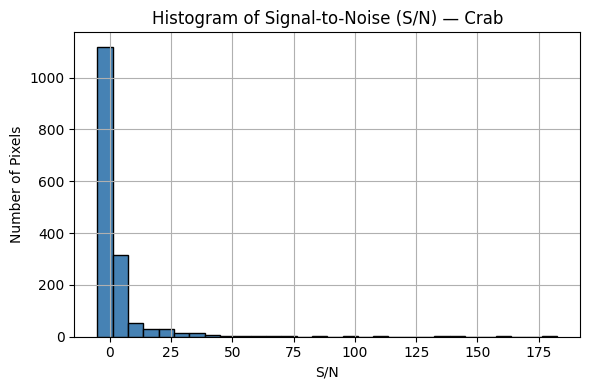

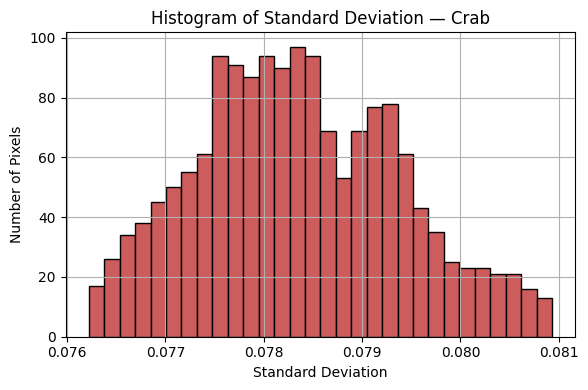

In [102]:
extent = [-detection_span, detection_span, -detection_span, detection_span]

# Signal-to-noise (S/N) map
plt.figure(figsize=(6, 5))
plt.imshow(s_flu / np.sqrt(s_var), origin='lower', cmap='viridis', extent=extent)
plt.title("Stacked S/N Map at Crab Nebula's Position")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("S/N")
plt.tight_layout()

# Effective exposure map (normalized)
plt.figure(figsize=(6, 5))
plt.imshow(s_expo / total_max_isgri_exp, origin='lower', cmap='magma', extent=extent)
plt.title("Normalized Stacked Exposure Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Relative Exposure")
plt.tight_layout()

# Square root of the variance map
plt.figure(figsize=(6, 5))
plt.imshow(np.sqrt(s_var), origin='lower', cmap='inferno', extent=extent)
plt.title("Stacked Standard Deviation Map (Crab)")
plt.xlabel("Δ Pixel X")
plt.ylabel("Δ Pixel Y")
cbar = plt.colorbar()
cbar.set_label("Standard Deviation")
plt.tight_layout()

# Histogram of S/N
plt.figure(figsize=(6, 4))
plt.hist((s_flu / np.sqrt(s_var)).flatten(), bins=30, color='steelblue', edgecolor='black')
plt.title("Histogram of Signal-to-Noise (S/N) — Crab")
plt.xlabel("S/N")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()

# Histogram of √variance
plt.figure(figsize=(6, 4))
plt.hist(np.sqrt(s_var).flatten(), bins=30, color='indianred', edgecolor='black')
plt.title("Histogram of Standard Deviation — Crab")
plt.xlabel("Standard Deviation")
plt.ylabel("Number of Pixels")
plt.grid(True)
plt.tight_layout()
